# MLOps for RSEs - 2. Data Preparation and Exploration

The first part of a machine learning project is to produce a dataset that can be used to train and optimise one or more machine learning models. In many ways this part is the most familiar for RSEs as datasets are gathered and processed routinely for almost all research projects rather than being a particular requirement for ML projects. There are some challenges in creating a *good* dataset for use in an ML project. This notebook will look at what the requirements for the data pipeline are that RSEs will need to support and some tools and practices that can make this process easier. 

![Met Office Logo](https://www.metoffice.gov.uk/webfiles/1661941781161/images/icons/social-icons/default_card_315.jpg)


## Building a data preparation pipeline

Exactly what a data preparation pipeline will look like is of course very problem and domain dependant. Of all the parts of a machine learning project, this is the part that is most likely to include "domain specific" tools, that is tools that are specific to the particular area of research covered by the project, rather than generic data science or machine learning tools that will be used in most of the rest of an ML project. The key parts of a pipeline include:

* Data Gathering - The first step is to get the data together that will be used to create the final output. The data might be coming from public datasets, generated by a simulation, gathered from observation (either by you or some one else), scraped from the web or many other possible locations. Many ML projects involve combining data from different sources. Some times the data are easy to use together, other times a lot of subsequent processing will be required for the data to be *analysis-ready*, or more specifically *machine learning-ready*.
  * Distributed processing - In some cases you may like to do some of the subsequent processing steps in a distributed fashion wherever the data is located rather than first gathering the data in a single location, particular where the processing involves subsetting and reduction that result in a much smaller output than input. Generally data transfer is expensive, so a good practice is to *take the compute to the data*. For example if data is located on a particular server and you need to extract data for a particular temporal and spatial location, it would be preferable to do that on the server if possible and then only copy across the data to be used to the central processing location for the project.
* Cleaning - Removing bad data or infilling missing data. Homogenising representations of data e.g. names of categories.
* Subsetting - Select the subset of interest for training your machine learning model.
* Transforming - Change the representation of your data to be consistent across data sources e.g. representing geospatial data on the same projection and grid.
* Calculating derived fields - A feature that combines various fields from raw data may be a better predictor, so such fields are typically calculated as part of the data preparation.
* Merging - Many machine learning projects bring together data from several sources which once the previous steps have been performed are merged into a single coherent dataset.
* Storing - Once the dataset has been created, it needs to be stored somewhere for reuse, ideally according to FAIR principles and somewhere access if efficient.
* Cataloging and Documenting - Add your dataset to a catalog or other collection of datasets to enable ease of find and (re)use.
* Exploring and Visualising - Enable researchers to explore the dataset through visualiations and summary statistics.

### Key Principles
* *reusability* - Create data processing components that are well engineered and can be reused in multiple pipelines.
* *scalability* - Be able to easily run processing workflows with whatever size dataset is required by the research problem.
* *interactivity* -  Enable research to interact with and explore

### Key Tasks for RSEs
* Setting up scalable infrastructure for running pipeline on large data
* Ensuring datasets created through pipeline are producible
* Informing design to ensure processing components are reusable
* Ensuring good management, documentation and testing of pipeline code
* Setting up infrastructure for sharing data

### Key Terms
* *FAIR* or *Findable, Accessible, Interoperable, Reusable* - Refers to key principles for sharing assets, egenrally, origininally data, but now also encompassing code, machine learning models and research objects generally. To effectively There amany definitions but a useful one from USGS is that analaysis ready data is *share them they follow these principles (taken from [go-fair.org](https://www.go-fair.org/fair-principles/)) 
  * Findable - The first step in (re)using data is to find them. Metadata and data should be easy to find for both humans and computers. Machine-readable metadata are essential for automatic discovery of datasets and services, so this is an essential component of the process of making assets FAIR.
  * Accessible - Once the user finds the required data, she/he/they need to know how they can be accessed, possibly including authentication and authorisation.
  * Interoperable - The data usually need to be integrated with other data. In addition, the data need to interoperate with applications or workflows for analysis, storage, and processing.
  * Reusable - The ultimate goal of FAIR is to optimise the reuse of data. To achieve this, metadata and data should be well-described so that they can be replicated and/or combined in different settings.
* *ARCO data* or *Analysis-ready, cloud-optimised data* - A way of secribing data that is as easy to use as possible for a variety of analsysis applications and stored in such a way that access patterns typical of cloud computing can be executed effficiently for the specific dataset.
    * Analysis-ready data - There amany definitions but a useful one from USGS is that aim of analaysis ready data is to make data *more accessible and easier to analyze, and reduce the amount of time users spend on data processing for ... analysis.* [source - USGS](https://www.usgs.gov/faqs/what-are-us-landsat-analysis-ready-data-ard).
    * Cloud optmised - to take advantage of the compute available on demand on the cloud, generally requires a workflow that includes parallel execution. To enable this for data loading, the data eeds to be stored on disk in such a way that parallel reads and writes are not constrained by the way the data is stored.
* pipeline - A series of tasks or operations, preferably based on reusable components, where the input of one step in the pipeline is the output of the previous step.
* workflow - similar to a pipeline as a series of tasks, but there may be multiple consecutive or parallel pipelines in a workflow. (Definitions may differ!)
* catalog - A machine readbale document describing a dataset or collection of datasets that enable one to load a dataset or subset directly into memory, abstracting away the machanics of storage such as handling of files.

### Key Tools

Many of the steps will be making use of the domain knowledge of researchers in project (e.g. ecologists, doctors, economists, psychologists etc.) and will need to make use of domain specific tools to handle the particular sorts of data. There are also many generic components, particularly around infrastructure, that can support the use of the domain specific tools:
* workflow management and scaling (dask, ray)
* environment management (conda, docker)
* visualisation (matplotlib, holoviz)
* catalog (intake)


### Running this notebook
This notebook should run from a conda environment created with the [requirements_data_prep.yml file](requirements_data_prep.yml). See the [readme file](https://github.com/informatics-lab/ukrse_2022_mlops_walkthrough/blob/main/README.md) for info on how to set up a conda environment for using this notebook.

## Example Problem -  Predicting impactful turbulent wind gusts

The first dataset we will explore comes from a challenge by a Met Office Chief Operational Meteorologist. In certain locations around the world turbulent lee wave gusts called *rotors* can cause problems for aviation. These are localised, topographically-driven, turbulent wind gusts and where these occur at an airfield make conditions sufficiently hazardous so as to cause operations to be suspended. Rotors therefore impact the aviation industry, in particular where flights have to be diverted for considerable distances from isolated airfields.  

What is needed is a prediction of whether such rotors are likely in a given time window, so that flight can be postponed or cancelled rather than risking the flight and turning back wasting fuel. As these are small scale features, they are not explicitly resolved in coarse resolution global models. Human OpMets are able to look at this model data and determine whether rotors are likely, but this is error-prone and time consuming. Can we train a machine learning algorithm to act as a tool to help OpMets with this process and provide a second opinion? In particular, a machine learning solution that can easily look at multiple model outputs (ensemble output, different forecast centres e.g. ECMWF).

The target is a human-created dataset produced by Operational Meteorologists at the airfield, as to whether a rotor occurred in any given three hour period.

![Lee Wave Rotors Diagram](rotors_diagram.png)

[Met Office Youtube video explaining rotors](https://www.youtube.com/watch?v=jgSZG9SqN_s)

## Example 1 - Exploring and preparing Wind Rotors data

We will start by exploring the wind rotors data set, and cleaning and preparing the data for machine learning as described above. First we will load in the "raw" dataset into a data frame. In this particular instance we won't use the standard library for dataframes *pandas*, instead we will use the dataframe implementation supplied dask. This supports *lazy loading* natively, so instead of loading our dataset that may be too large to fit in memory, or may just require waiting a long time for it to load, it reads only the *metadata* which tells it enough to construct a stub data structure and plan the computations. Any subsequent calculation will similarly not actually be executed when called, but rather continue the *lazy execution* paradigm. This creates a *task graph* which represents the chain of tasks in our workflow. 

When we have constructed the graph representing the workflow, we can then trigger execution of all the steps. An additional advantage is that we can send the workflow to another, potentially shared remote, platform from our interactive compute (e.g. local laptop, notebooks server) which may have more substantial resources (more memory, many CPUs, specialised processors like GPUs).

In [1]:
import pathlib
import os
import functools
import math

In [2]:
import pandas

In [3]:
import matplotlib
import matplotlib.pyplot

In [4]:
import dask
import dask.dataframe
import dask.distributed

The data is available from Zenodo. See the [readme file](README.md) file for details. You can download the data into the default location of `~/data/ukrse2022` or you can specify the location in the environment variable `${RSE22_ROOT_DATA_DIR}`.

In [12]:
try:
    rse_root_data_dir = pathlib.Path(os.environ['RSE22_ROOT_DATA_DIR'])
    print('reading from environment variable')
except KeyError as ke1:
    rse_root_data_dir = pathlib.Path(os.environ['HOME'])  / 'data' / 'ukrse2022'
    print('using default path')
print(rse_root_data_dir.is_dir())
rse_root_data_dir

using default path
True


PosixPath('/home/h01/shaddad/data/ukrse2022')

In [6]:
load_from_zenodo=False
zenodo_record_root = 'https://zenodo.org/record/7022648/files/'

In [7]:
pathlib.Path(f'{zenodo_record_root}') / '2021_met_office_aviation_rotors.csv'

PosixPath('https:/zenodo.org/record/7022648/files/2021_met_office_aviation_rotors.csv')

In [8]:
rotors_fname = '2021_met_office_aviation_rotors.csv'
if load_from_zenodo:
    rotors_path = f'{zenodo_record_root}/{rotors_fname}'
else:
    rotors_path = rse_root_data_dir / rotors_fname
    print(rotors_path.is_file())
rotors_path

False


PosixPath('/home/h01/shaddad/data/ukrse2022/2021_met_office_aviation_rotors.csv')

### Set up the cluster - Dask

For this example we are using a simple local cluster. This is the only part of the code that would need to change to execute the subsequent code on a large cluster or cloud based cluster (in theory at least, there are often additional steps needed around python environments, which are getting easier as the tools mature).

There are two steps in. this part, firstly initiating the cluster, then creating a client to access the cluster. In a complicated separate, the cluster set up step is likely to happen elsewhere through a command line interface, or together with a container or cloud orchestration software like [kubernetes](https://kubernetes.io/) or [docker swarm](https://docs.docker.com/engine/swarm/).

In [9]:
local_cluster = dask.distributed.LocalCluster(n_workers=4)
local_cluster

LocalCluster(53caabff, 'tcp://127.0.0.1:44328', workers=4, threads=4, memory=7.62 GiB)

In [10]:
dask_client = dask.distributed.Client(local_cluster)
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.62 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44328,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.62 GiB
Comm: tcp://127.0.0.1:41050,Total threads: 1
Dashboard: http://127.0.0.1:35084/status,Memory: 1.90 GiB
Nanny: tcp://127.0.0.1:38778,


### Prepare and execute data reading tasks

Now that we have prepared the cluster for our tasks, we can set up workflow through a series lazy execution function calls. The code looks exactly the same as if the computation were to happen immediately, but instead if we look at the returned objects, we don't see the actual data objects, but *delayed* proxy objects which contain the data required for executing the workflow tasks when requested to do so.

In [11]:
rotors_path

PosixPath('/home/h01/shaddad/data/ukrse2022/2021_met_office_aviation_rotors.csv')

In [13]:
rotors_df = dask.dataframe.read_csv(rotors_path)
rotors_df

,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,air_temp_5,air_temp_6,air_temp_7,air_temp_8,air_temp_9,air_temp_10,air_temp_11,air_temp_12,air_temp_13,air_temp_14,air_temp_15,air_temp_16,air_temp_17,air_temp_18,air_temp_19,air_temp_20,air_temp_21,air_temp_22,sh_1,sh_2,sh_3,sh_4,sh_5,sh_6,sh_7,sh_8,sh_9,sh_10,sh_11,sh_12,sh_13,sh_14,sh_15,sh_16,sh_17,sh_18,sh_19,sh_20,sh_21,sh_22,winddir_1,windspd_1,winddir_2,windspd_2,winddir_3,windspd_3,winddir_4,windspd_4,winddir_5,windspd_5,winddir_6,windspd_6,winddir_7,windspd_7,winddir_8,windspd_8,winddir_9,windspd_9,winddir_10,windspd_10,winddir_11,windspd_11,winddir_12,windspd_12,winddir_13,windspd_13,winddir_14,windspd_14,winddir_15,windspd_15,winddir_16,windspd_16,winddir_17,windspd_17,winddir_18,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,Rotors 1 is true
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [14]:
rotors_df.columns

Index(['DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7',
       'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12',
       'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16',
       'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20',
       'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5',
       'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13',
       'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21',
       'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2',
       'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5',
       'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7',
       'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10',
       'windspd_10', 'winddir_11', 'windspd_11', 'windd

In [15]:
try:
    x = rotors_df['rotors_present']
except KeyError:
    rot_df = rotors_df.compute()
    rot_df = rot_df.rename(columns={'Rotors 1 is true' : 'rotors_present'})
    rot_df['rotors_present'].fillna(value=0.0, inplace=True)
    os.remove(rotors_path)
    rot_df.to_csv(rotors_path)
    rotors_df = dask.dataframe.read_csv(rotors_path)

In [16]:
target_feature_name = 'rotors_present'

In [17]:
rotors_df  = rotors_df [(rotors_df ['wind_speed_obs'] >= 0.0) &
                            (rotors_df ['air_temp_obs'] >= 0.0) &
                            (rotors_df ['wind_direction_obs'] >= 0.0) &
                            (rotors_df ['dewpoint_obs'] >= 0.0) 
                           ]

In [18]:
rotors_df.dask

layer_type,DataFrameIOLayer
is_materialized,False
number of outputs,1
npartitions,1
columns,"['Unnamed: 0', 'DTG', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs', 'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2', 'air_temp_3', 'air_temp_4', 'air_temp_5', 'air_temp_6', 'air_temp_7', 'air_temp_8', 'air_temp_9', 'air_temp_10', 'air_temp_11', 'air_temp_12', 'air_temp_13', 'air_temp_14', 'air_temp_15', 'air_temp_16', 'air_temp_17', 'air_temp_18', 'air_temp_19', 'air_temp_20', 'air_temp_21', 'air_temp_22', 'sh_1', 'sh_2', 'sh_3', 'sh_4', 'sh_5', 'sh_6', 'sh_7', 'sh_8', 'sh_9', 'sh_10', 'sh_11', 'sh_12', 'sh_13', 'sh_14', 'sh_15', 'sh_16', 'sh_17', 'sh_18', 'sh_19', 'sh_20', 'sh_21', 'sh_22', 'winddir_1', 'windspd_1', 'winddir_2', 'windspd_2', 'winddir_3', 'windspd_3', 'winddir_4', 'windspd_4', 'winddir_5', 'windspd_5', 'winddir_6', 'windspd_6', 'winddir_7', 'windspd_7', 'winddir_8', 'windspd_8', 'winddir_9', 'windspd_9', 'winddir_10', 'windspd_10', 'winddir_11', 'windspd_11', 'winddir_12', 'windspd_12', 'winddir_13', 'windspd_13', 'winddir_14', 'windspd_14', 'winddir_15', 'windspd_15', 'winddir_16', 'windspd_16', 'winddir_17', 'windspd_17', 'winddir_18', 'windspd_18', 'winddir_19', 'windspd_19', 'winddir_20', 'windspd_20', 'winddir_21', 'windspd_21', 'winddir_22', 'windspd_22', 'rotors_present']"
type,dask.dataframe.core.DataFrame
dataframe_type,pandas.core.frame.DataFrame
series_dtypes,
layer_type,Blockwise
is_materialized,False
number of outputs,1


In [19]:
rotors_df ['DTG'] = dask.dataframe.to_datetime(rotors_df['DTG'])

In [20]:
rotors_df  = rotors_df .drop_duplicates(subset=['DTG'])

In [21]:
rotors_df  = rotors_df [~rotors_df['DTG'].isnull()]

In [22]:
rotors_df_delayed = rotors_df
rotors_df_delayed

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,air_temp_5,air_temp_6,air_temp_7,air_temp_8,air_temp_9,air_temp_10,air_temp_11,air_temp_12,air_temp_13,air_temp_14,air_temp_15,air_temp_16,air_temp_17,air_temp_18,air_temp_19,air_temp_20,air_temp_21,air_temp_22,sh_1,sh_2,sh_3,sh_4,sh_5,sh_6,sh_7,sh_8,sh_9,sh_10,sh_11,sh_12,sh_13,sh_14,sh_15,sh_16,sh_17,sh_18,sh_19,sh_20,sh_21,sh_22,winddir_1,windspd_1,winddir_2,windspd_2,winddir_3,windspd_3,winddir_4,windspd_4,winddir_5,windspd_5,winddir_6,windspd_6,winddir_7,windspd_7,winddir_8,windspd_8,winddir_9,windspd_9,winddir_10,windspd_10,winddir_11,windspd_11,winddir_12,windspd_12,winddir_13,windspd_13,winddir_14,windspd_14,winddir_15,windspd_15,winddir_16,windspd_16,winddir_17,windspd_17,winddir_18,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
npartitions=1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [23]:
no_rotors_df = rotors_df[rotors_df[target_feature_name] == False]
rotors_present_df = rotors_df[rotors_df[target_feature_name] == True]

In [24]:
no_rotors_df.shape, rotors_df.shape

((Delayed('int-1f2afb82-9c6d-4d57-8e34-533aeead8f39'), 96),
 (Delayed('int-223a45ea-7ba0-42b1-af4e-d4ef90720932'), 96))

To get the data, we have to execute the task graph on the cluster. We should now see something happen on the dask dashboard.

In [25]:
no_rotors_df = no_rotors_df.compute()
rotors_present_df = rotors_present_df.compute()

In [26]:
no_rotors_df.shape, rotors_present_df.shape

((17037, 96), (449, 96))

In [27]:
no_rotors_df

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
1,1,2015-01-01 00:00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2,2015-01-01 03:00:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,3,2015-01-01 06:00:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,4,2015-01-01 09:00:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
5,5,2015-01-01 12:00:00,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,...,1.6,273.0,2.0,303.0,2.3,329.0,2.5,338.0,2.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,2020-12-31 06:00:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,20102,2020-12-31 09:00:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,20103,2020-12-31 12:00:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,20104,2020-12-31 15:00:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


Part of the data preparation process is often to create derived features that will be more useful as input for the machine learning algorithm. This is one way to include the knowledge of researchers into a machine learning pipeline through *feature engineering* which embed the known relationships and important values in the data in the way the dataset is presented for training. 

Here we want to present wind as two vectors in the u direction (east-west) and the v-direction (north-south), as our research meteorologists know this is likely to be more useful in predicting these wind rotors events.

In [28]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]

In [29]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [30]:
%%time
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    rotors_df[u_feature] = rotors_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns', meta=(None, 'float64'))
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    rotors_df[v_feature] = rotors_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns', meta=(None, 'float64'))

CPU times: user 827 ms, sys: 23.3 ms, total: 851 ms
Wall time: 889 ms


In [31]:
rotors_df = rotors_df.compute()

In [32]:
rotors_df['time'] = rotors_df['DTG']
rotors_df = rotors_df.drop(['DTG'], axis='columns')

Our data is now cleaned up and ready to be saved our as a preprocessed, analysis ready dataset.

In [33]:
rotors_df                                                   

,Unnamed: 0,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,v_wind_18,u_wind_19,v_wind_19,u_wind_20,v_wind_20,u_wind_21,v_wind_21,u_wind_22,v_wind_22,time
1,1,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.756768,-1.953409,5.673111,-2.674064,5.482644,-3.000000e+00,5.196152,-2.987221,4.971570,2015-01-01 00:00:00
2,2,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.502872,-1.460878,5.094687,-0.790064,3.716961,-7.837740e-16,3.200000,0.727691,3.423517,2015-01-01 03:00:00
3,3,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,5.481273,-1.423505,5.312592,-0.174497,4.996954,7.293223e-01,4.136193,2.462646,3.152043,2015-01-01 06:00:00
4,4,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,2.475770,-1.311123,3.245143,-0.407661,3.878635,6.883116e-01,4.345829,1.723190,4.265046,2015-01-01 09:00:00
5,5,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,-0.775695,-1.997259,0.104672,-1.928942,1.252670,-1.287595e+00,2.142918,-0.899056,2.225241,2015-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,-8.555992,-8.047581,-8.629974,-7.479073,-8.603689,-7.111320e+00,-8.781749,-6.538771,-9.338333,2020-12-31 06:00:00
20102,20102,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,-6.956383,-8.273280,-6.942106,-8.886116,-7.456336,-8.995651e+00,-8.388580,-8.029567,-8.917738,2020-12-31 09:00:00
20103,20103,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,-8.332875,-7.326372,-9.377328,-8.397556,-9.660283,-7.962654e+00,-8.843423,-7.495332,-7.495332,2020-12-31 12:00:00
20104,20104,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,-6.646804,-5.294689,-6.776892,-4.398330,-7.038799,-5.356255e+00,-6.855694,-7.265332,-7.016050,2020-12-31 15:00:00


In [34]:
rotors_preprocessed_path = rse_root_data_dir / (pathlib.Path(rotors_fname).stem + '_preprocessed.csv')
rotors_preprocessed_path

PosixPath('/home/h01/shaddad/data/ukrse2022/2021_met_office_aviation_rotors_preprocessed.csv')

In [35]:
rotors_df.to_csv(rotors_preprocessed_path)

### Create an interactive dashboard for data exploration
Part of the initial process of a machine learning project is to explore the contents of the dataset, especially where it is unfamiliar to those researchers working with it. You may wish to get a sense of the values, structures and relationships in the data. There are a variety of ways to do this, through visualising the "raw" data directly, or summary statistics and derived metrics and indices which describe the data. Often it will be helpful to be able to share both the results of the *exploratory data analysis* and access to exploratory code itself. This can be done without having to run code directly by quickly creating a *dashboard* use one of the many python, R, javascript or other language tools to do this. This allows a range of experts in different areas to explore the data to inform subsequent data analysis and modelling choices use in the machine learning pipeline.

Here we demonstrate the use of tools in the [holoviz ecosystem](https://holoviz.org/)

In [36]:
import panel
panel.extension()

In [37]:
rotors_df.columns

Index(['Unnamed: 0', 'air_temp_obs', 'dewpoint_obs', 'wind_direction_obs',
       'wind_speed_obs', 'wind_gust_obs', 'air_temp_1', 'air_temp_2',
       'air_temp_3', 'air_temp_4',
       ...
       'v_wind_18', 'u_wind_19', 'v_wind_19', 'u_wind_20', 'v_wind_20',
       'u_wind_21', 'v_wind_21', 'u_wind_22', 'v_wind_22', 'time'],
      dtype='object', length=140)

In [38]:
model_vars_dict = {
    'Temperature': 'air_temp',
    'Specific Humidity': 'sh',
    'Wind Direction': 'winddir' ,
    'Wind Speed': 'windspd' ,
           }

In [39]:
obs_dict = {
    'Temperature': 'air_temp_obs',
    'Dew Point Temperature': 'dewpoint_obs',
    'Wind Direction': 'wind_direction_obs' ,
    'Wind Speed': 'wind_speed_obs' ,
}

In [40]:
def do_histogram(plotting_df, rotors_feature_name, selected_var, subset):
    fig1 = matplotlib.pyplot.figure(f'histogram of {selected_var}')
    ax1 = fig1.add_subplot(1,1,1,title=f'histogram of {selected_var}')
    if subset == 'all':
        data_to_plot = plotting_df
    elif subset == 'no_rotors':
        data_to_plot = plotting_df[plotting_df[rotors_feature_name] == 0.0]
    elif subset == 'rotors_present':
        data_to_plot = plotting_df[plotting_df[rotors_feature_name] == 1.0]
    _ = data_to_plot[selected_var].plot.hist(bins=20, ax=ax1)
    return fig1

In [41]:
hist_var_select = panel.widgets.Select(
    options=obs_dict,
    name='selected_var',
)

In [42]:
subset_select = panel.widgets.Select(
    options = ['all', 'no_rotors', 'rotors_present'],
    name='subset',
)

In [43]:
hist_plotter = panel.bind(
    functools.partial(
        do_histogram,
        plotting_df=rotors_df,
        rotors_feature_name=target_feature_name,
        ),
    selected_var=hist_var_select,
    subset=subset_select,
)

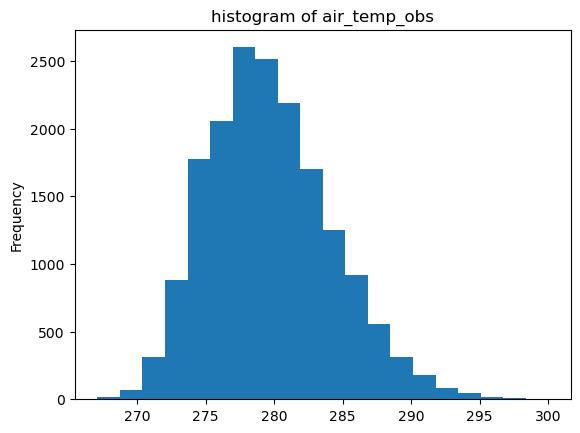

In [44]:
rotors_dash = panel.Column(
    panel.widgets.StaticText(value='Rotors Data Exploration Dashboard'),
    panel.Row(subset_select, hist_var_select),
    hist_plotter)

Column
    [0] StaticText(value='Rotors Data E...)
    [1] Row
        [0] Select(name='subset', options=['all', 'no_rotors', ...], value='all')
        [1] Select(name='selected_var', options={'Temperature': 'air_temp_...}, value='air_temp_obs')
    [2] ParamFunction(function)
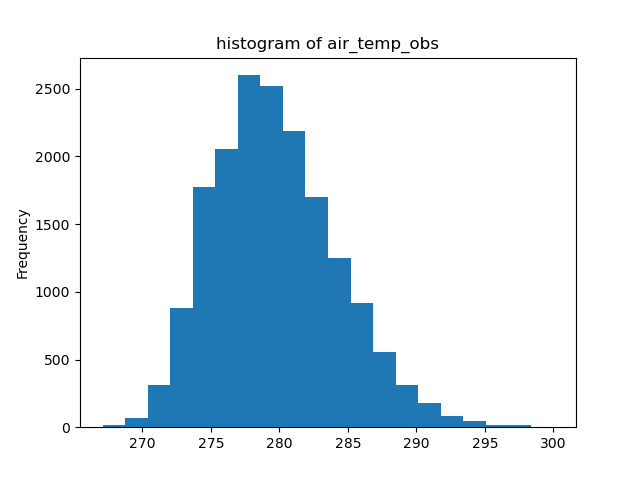

In [45]:
rotors_dash.servable()

In the above example, we see a very simple dashboard to visualise some statistics about the data. This could be extended to any particular plots that are of interest to the researchers, which can easily be created in a standard script or notebook and then subsequently included in dashboard code. 

This code could also be put in it own script of course, or run on a website directly from the notebook using the panel library from the command line:
```
panel serve 02_data_prep.ipynb
```

## Example 2 - Weather Types from ERA5 Reanalysis Dataset

Our next example further explores processing at scale on a different sort of data often called *gridded data* in environmental science. This is essentially data that has a similar structure to image or more generally *raster* data. The difference here is that our grid may extend in n dimensions, such as latitude, longitude, height above the surface, time, ensemble realisation etc. Here we use the ERA5 reanalysis dataset to create "weather regime clusters", that is find groups of air pressure patterns that are similar and are likely to be associated with similar sorts of weather. One could use experts to describe what they think such patterns would be, or one can use a data driven approach like clustering to find what patterns are actually present in the data and may reveal patterns that had not been previously considered.

Further information on weather regimes:
* https://www.metoffice.gov.uk/services/business-industry/energy/decider
* https://www.metoffice.gov.uk/research/news/2016/new-weather-patterns-for-uk-and-europe


The particular challenges in this problem are again around the scale of the data requiring processing, but also around the use of domain specific libraries for processing. We will often need to use various domain specific tools and techniques in the data preparation part of the pipeline to prepare the data for use with more generic machine learning and data science tools. In this example we are using the Met Office python library [Iris](https://scitools-iris.readthedocs.io/en/stable/), which handles gridded meteorological (i.e. climate and weather) data and metadata and includes various meteorology specific functionality and handles specific data storage formats such as *NetCDF* and *Grib2*. Other research domains will have similar packages for handling their specific needs, which will similarly need to be supported as part of a machine learning projects in those research domains.

Docs:
* [Iris](https://scitools-iris.readthedocs.io/en/stable/)
* [Xarray](https://docs.xarray.dev/en/stable/) (similar package) 

In [46]:
import iris
import iris.coord_categorisation
import iris.quickplot

In [47]:
import cartopy
import cartopy.crs

### Accessing the raw data
The full global ERA5 files can most easily be accessed through a [public bucket on s3](https://registry.opendata.aws/ecmwf-era5/)
You can either follow the instructions to access it directly from python using the instructions on the above link, or you can download a local copy using the aws s3 command line tool as follows:

`aws s3 cp --no-sign-request s3://era5-pds/2019/01/data/air_pressure_at_mean_sea_level.nc ~/data/ukrse2022/`

The data files are for one month at a time, so you would need to do this for all months from January 2017 to December 2019 to execute the code below. The total size for that data is 35GB, so you may wish to rather just used the pre-prepared subset available through Zenodo as described in the readme.


In [48]:
try:
    era5_data_dir = pathlib.Path(os.environ['RSE22_ERA5_DATA_DIR'])
    print('reading from environment variable')
except KeyError as ke1:
    era5_data_dir = pathlib.Path(os.environ['HOME'])  / 'data' / 'ukrse2022'
    print('using default path')
era5_data_dir

using default path


PosixPath('/home/h01/shaddad/data/ukrse2022')

In [49]:
era5_global_paths = sorted([p1 for p1 in era5_data_dir.iterdir() if '.nc' in str(p1) and 'air_pressure' in str(p1)])

In [50]:
uk_na_bounds = {'latitude': (40,65), 'longitude': (-10,10)}

In [51]:
do_global_extract = False

In [52]:
era5_mslp_uk_subset_fname = 'era5_mslp_UK_2017_2020.nc'

In [53]:
import xarray

In the initial extraction code below, we load all the downloaded data files, tidy up some of the metadata using the `equalise_attributes` function, then join the data from each month into a single *cube*, which is what iris calls a multidimensional gridded dataset describing a single physical phenomenon or feature (in ML jargon) e.g. air temperature or air pressure. We then extract a subset of that data covering the United Kingdom and parts of the North Atlantic and North Sea. 

The UK subset of ERA5 data is available from Zenodo. See the [readme file](README.md) file for details. You can download the data into the default location of `~/data/ukrse2022` or you can specify the location in the environment variable `${RSE22_ROOT_DATA_DIR}`.

In [55]:
if do_global_extract:
    print('do global_extract')
    era5_global_cubeList = iris.load(map(str, era5_global_paths))
    iris.util.equalise_attributes(era5_global_cubeList)
    mslp_era5_cube = iris.cube.CubeList.concatenate_cube(era5_global_cubeList)
    mslp_era5_uk_cube = mslp_era5_cube.intersection(latitude=uk_na_bounds['latitude'], 
                                                longitude=uk_na_bounds['longitude'])
else:
    print('loading cached data')
    if load_from_zenodo:
        mslp_era5_uk_cube = xarray.load_dataarray(zenodo_record_root  + era5_mslp_uk_subset_fname).to_iris()
    else:
        mslp_era5_uk_cube = iris.load_cube(str(era5_data_dir / era5_mslp_uk_subset_fname))


loading cached data


In [56]:
mslp_era5_uk_cube

Air Pressure At Mean Sea Level (Pa),time,latitude,longitude
Shape,35064,101,81
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Attributes,,,Conventions CF-1.7institution ECMWFnameCDM Mean_sea_level_pressure_surfacenameECMWF Mean sea level pressureproduct_type analysisshortNameECMWF mslsource Reanalysis


In [57]:
print(type(mslp_era5_uk_cube.core_data()))
mslp_era5_uk_cube.core_data()

<class 'dask.array.core.Array'>


dask.array<array, shape=(35064, 101, 81), dtype=float32, chunksize=(3896, 101, 81), chunktype=numpy.ndarray>

The calculation we want to do here is remove differences between seasons. What we're interested in is pressure anomalies, that is how the pressure pattern differs from what is normal for the time of year. So we want to calculate the average pressure at each point for each season. There is a lot of data so this is a large calculation, so the large compute resources we can get access to through an appropriately resourced dask cluster, especially if we were doing this on the full ERA5 data of several decades and for a larger area.

In [58]:
iris.iris.coord_categorisation.add_season_number(mslp_era5_uk_cube,'time')


In [59]:
mslp_uk_seasonal_mean = mslp_era5_uk_cube.aggregated_by(['season_number'],iris.analysis.MEAN)
mslp_uk_seasonal_mean

<iris 'Cube' of air_pressure_at_mean_sea_level / (Pa) (-- : 4; latitude: 101; longitude: 81)>

In [60]:
mslp_uk_seasonal_mean.core_data()

dask.array<stack, shape=(4, 101, 81), dtype=float32, chunksize=(1, 101, 81), chunktype=numpy.ndarray>

In [61]:
uk_season_dict = {
    'NH Winter': 0,
    'NH Spring': 1,
    'NH Summer': 2,
    'NH Autumun': 3,
}

Next researcher may again want to explore the content of the dataset using a nice dashboard created with holoviz.

In [62]:
def plot_seasonal_mean(plotting_cube, season):
    print(f'season {season}')
    fig1 = matplotlib.figure.Figure()
    fig1.clf()
    ax1 = fig1.add_subplot(1,1,1,projection=cartopy.crs.PlateCarree())
    _ = iris.quickplot.contourf(plotting_cube[season],axes=ax1)
    ax1.coastlines()    
    return fig1

In [63]:
season_select = panel.widgets.Select(options=uk_season_dict, 
                                     value=2,
                                     name='season'
                                     )

In [64]:
season_plotter = panel.bind(
    functools.partial(plot_seasonal_mean, mslp_uk_seasonal_mean),
    season=season_select,
)


season 2


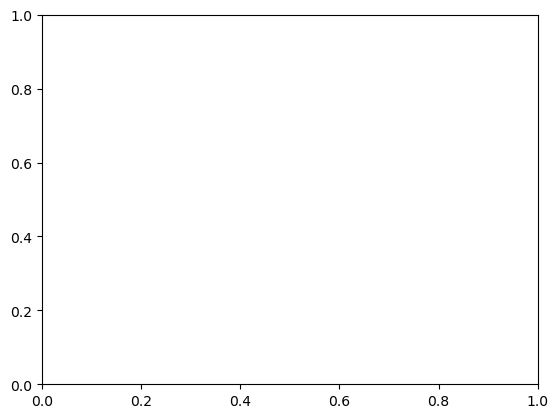

In [65]:
seasons_dash = panel.Column(season_select, season_plotter)

Column
    [0] Select(name='season', options={'NH Winter': 0, ...}, value=2)
    [1] ParamFunction(function)
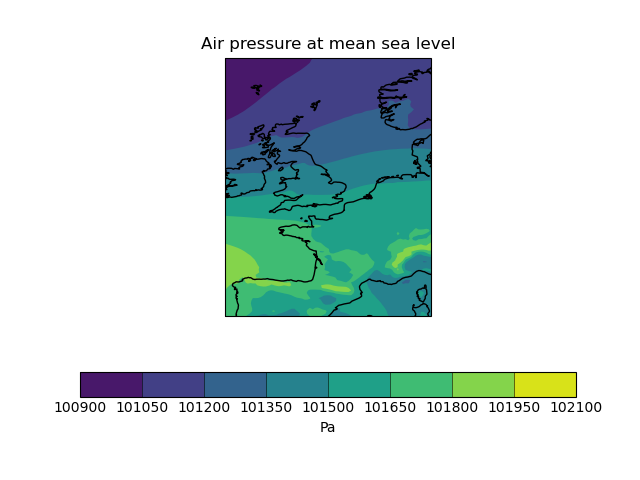

In [66]:
seasons_dash.servable()

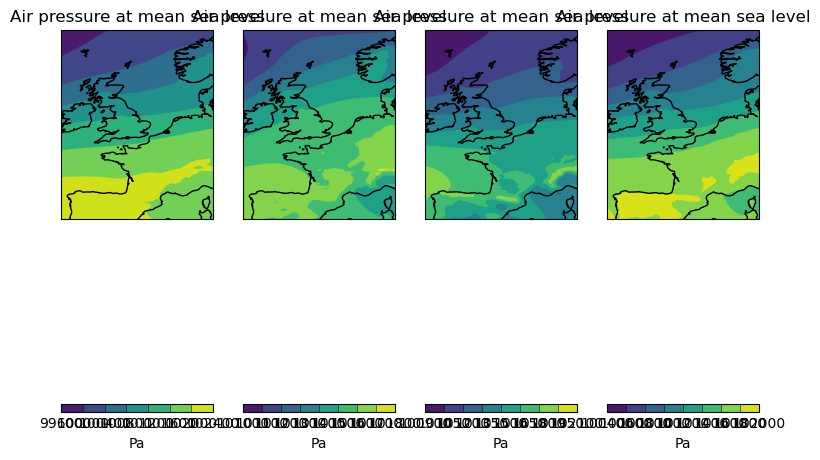

In [67]:
fig1 = matplotlib.pyplot.figure(figsize=(9,16))
for ix1 in range(mslp_uk_seasonal_mean.shape[0]):
    ax1 = fig1.add_subplot(1,4,ix1+1,projection=cartopy.crs.PlateCarree())
    iris.quickplot.contourf(mslp_uk_seasonal_mean[ix1],axes=ax1)
    ax1.coastlines()

In [68]:
era5_flat_deseasoned = dask.array.concatenate(
    [(mslp_era5_uk_cube.extract(iris.Constraint(season_number=sn1)).core_data() - mslp_uk_seasonal_mean[sn1].core_data()).reshape(
    (-1, mslp_era5_uk_cube.shape[1] * mslp_era5_uk_cube.shape[2])) for sn1 in range(4)],
    axis=0
)
era5_flat_deseasoned

dask.array<concatenate, shape=(35064, 8181), dtype=float32, chunksize=(2208, 8181), chunktype=numpy.ndarray>

In [69]:
era5_flat_deseasoned = era5_flat_deseasoned.compute()

## Example 3 - Creating a catalog with Intake

When you think of a dataset, you probably think of a series of files in some format (often NetCDF files for weather and climate data, maybe [FITS](https://en.wikipedia.org/wiki/FITS) in astronomy or [BAM files](https://samtools.github.io/hts-specs/SAMv1.pdf) in genetics. Researchers in general don't care about the files themselves, but rather getting the data they contained loaded in memory. There are now better options for presenting data than just a unorder collection of files. One such option is a *catalog*. The idea here is the curated data files are presented logically in terms of the different datasets, which each logical dataset is presented as a single object, irrespective of how the data is actually stored on disk. There could be one file or many files, or it could be coming from a database or an API, the researcher sees a dataset, which can then be requested and loaded into memory (either actually loading the data or setting up a stub for subsequent lazy loading and lazy execution).

Here we create a very basic catalog of the data we would like to make available to researchers using the data catalogue tool called *intake*. This is a very lightweight framework for creating catalog. There are two parts to such a catalog:

* Catalog description - A yml file describing what is in the dataset available through the catalog
* Data Driver - A script which knows how to load the data in question and return an in memory data object. This is generally provided for many existing popular data formats. It is also fairly easy to write one's own driver for new data formats (for example environmental data formats are well supported, but perhaps medical data formats are less well supported). 

In [70]:
import intake

In [71]:
rotors_catalog = intake.open_catalog(rse_root_data_dir / 'rotors_catalog.yml')
rotors_catalog 

rotors_catalog:
  args:
    path: /home/h01/shaddad/data/ukrse2022/rotors_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [72]:
list(rotors_catalog)

['rotors', 'rotors_preprocessed']

In [73]:
rotors_catalog['rotors'].read()

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


Our catalog could have been pointing to any source of data, the details are abstracted by the catalog software, in this Intake. Now we will take quick look at programmatically creating a catalog from one or more data sources.

In [74]:
import fsspec

In [75]:
rotors_df

,Unnamed: 0,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,air_temp_4,...,v_wind_18,u_wind_19,v_wind_19,u_wind_20,v_wind_20,u_wind_21,v_wind_21,u_wind_22,v_wind_22,time
1,1,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,282.625,...,5.756768,-1.953409,5.673111,-2.674064,5.482644,-3.000000e+00,5.196152,-2.987221,4.971570,2015-01-01 00:00:00
2,2,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,280.250,...,6.502872,-1.460878,5.094687,-0.790064,3.716961,-7.837740e-16,3.200000,0.727691,3.423517,2015-01-01 03:00:00
3,3,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,278.625,...,5.481273,-1.423505,5.312592,-0.174497,4.996954,7.293223e-01,4.136193,2.462646,3.152043,2015-01-01 06:00:00
4,4,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,278.250,...,2.475770,-1.311123,3.245143,-0.407661,3.878635,6.883116e-01,4.345829,1.723190,4.265046,2015-01-01 09:00:00
5,5,279.9,277.4,120.0,8.7,-9999999.0,279.250,278.875,278.375,277.875,...,-0.775695,-1.997259,0.104672,-1.928942,1.252670,-1.287595e+00,2.142918,-0.899056,2.225241,2015-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,277.500,...,-8.555992,-8.047581,-8.629974,-7.479073,-8.603689,-7.111320e+00,-8.781749,-6.538771,-9.338333,2020-12-31 06:00:00
20102,20102,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,277.875,...,-6.956383,-8.273280,-6.942106,-8.886116,-7.456336,-8.995651e+00,-8.388580,-8.029567,-8.917738,2020-12-31 09:00:00
20103,20103,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,279.625,...,-8.332875,-7.326372,-9.377328,-8.397556,-9.660283,-7.962654e+00,-8.843423,-7.495332,-7.495332,2020-12-31 12:00:00
20104,20104,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,283.000,...,-6.646804,-5.294689,-6.776892,-4.398330,-7.038799,-5.356255e+00,-6.855694,-7.265332,-7.016050,2020-12-31 15:00:00


In [76]:
new_cat_fname = 'my_catalog.yml'

Here we use the fsspec library to open our file. fsspec abstracts away the details of the underlying file system, so you can use the same code to read/write file on a local storage system as on a cloud object store such as [AWS S3](https://aws.amazon.com/s3), [Google Cloud storage](https://cloud.google.com/products/storage) or [Azure Blob Storage](https://azure.microsoft.com/en-gb/services/storage/blobs). The details of how to load the file are taken care of by fsspec. This combined with a catalog makes it much easier for researchers to access datasets without worrying about the technical details of storage and loading.

In [77]:
intake.open_csv(fsspec.open_local(rotors_path)).read()

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


Now we can try to programmatically create a catalog 

In [78]:
intake.source.csv.CSVSource(fsspec.open_local(rotors_path)).yaml()

"sources:\n  csv:\n    args:\n      urlpath:\n      - /home/h01/shaddad/data/ukrse2022/2021_met_office_aviation_rotors.csv\n    description: ''\n    driver: intake.source.csv.CSVSource\n    metadata: {}\n"

In [79]:
with open(new_cat_fname , 'w') as cat_out:
    constructed_catalog = intake.open_csv(fsspec.open_local(rotors_path))
    constructed_catalog.description = '''Tabular dataset with observed and simulated weather data, 
    intended for use training a machine learning model predicting turbulent wind gust events.'''
    catalog_txt = constructed_catalog.yaml()
    print(catalog_txt)
    cat_out.write(catalog_txt)


sources:
  csv:
    args:
      urlpath:
      - /home/h01/shaddad/data/ukrse2022/2021_met_office_aviation_rotors.csv
    description: "Tabular dataset with observed and simulated weather data, \n   \
      \ intended for use training a machine learning model predicting turbulent wind\
      \ gust events."
    driver: intake.source.csv.CSVSource
    metadata: {}



In [80]:
new_catalog = intake.open_catalog(new_cat_fname)
new_catalog

my_catalog:
  args:
    path: my_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [81]:
new_catalog['csv'].read()

,Unnamed: 0,DTG,air_temp_obs,dewpoint_obs,wind_direction_obs,wind_speed_obs,wind_gust_obs,air_temp_1,air_temp_2,air_temp_3,...,windspd_18,winddir_19,windspd_19,winddir_20,windspd_20,winddir_21,windspd_21,winddir_22,windspd_22,rotors_present
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1,01/01/2015 00:00,283.9,280.7,110.0,4.1,-9999999.0,284.000,283.625,283.250,...,5.8,341.0,6.0,334.0,6.1,330.0,6.0,329.0,5.8,0.0
2,2,01/01/2015 03:00,280.7,279.7,90.0,7.7,-9999999.0,281.500,281.250,280.750,...,6.8,344.0,5.3,348.0,3.8,360.0,3.2,12.0,3.5,0.0
3,3,01/01/2015 06:00,279.8,278.1,100.0,7.7,-9999999.0,279.875,279.625,279.125,...,6.0,345.0,5.5,358.0,5.0,10.0,4.2,38.0,4.0,0.0
4,4,01/01/2015 09:00,279.9,277.0,120.0,7.2,-9999999.0,279.625,279.250,278.875,...,3.1,338.0,3.5,354.0,3.9,9.0,4.4,22.0,4.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20101,20101,31/12/2020 06:00,276.7,275.5,270.0,3.6,-9999999.0,277.875,277.750,277.625,...,12.1,223.0,11.8,221.0,11.4,219.0,11.3,215.0,11.4,0.0
20102,20102,31/12/2020 09:00,277.9,276.9,270.0,3.1,-9999999.0,277.875,277.625,277.875,...,10.2,230.0,10.8,230.0,11.6,227.0,12.3,222.0,12.0,0.0
20103,20103,31/12/2020 12:00,283.5,277.1,220.0,3.6,-9999999.0,281.125,280.625,280.125,...,10.3,218.0,11.9,221.0,12.8,222.0,11.9,225.0,10.6,0.0
20104,20104,31/12/2020 15:00,286.1,276.9,250.0,3.6,-9999999.0,284.625,284.125,283.625,...,9.4,218.0,8.6,212.0,8.3,218.0,8.7,226.0,10.1,0.0


* https://intake.readthedocs.io/en/latest/quickstart.html
* http://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/intake.html 
* https://medium.com/informatics-lab/archive-how-to-build-an-intake-catalog-c49182297572

### Next Steps and further reading

Here we have seen how we can use assorted tools an practices to make the data preparation part of a machine learning project more scalable and  reproducible, and also make the datasets created more FAIR through the use of catalogs to abstract away the details of data handling from a researcher who doesn't and shouldn't need to care about the technical details. We have used these tools in quite basic way, there are many more advanced options and tools that implement the same principles. Similarly there examples are very weather and climate focused as well as python centric. Different tools or languages will be used for different research areas (e.g. R and R Shiny may be popular)

* Scaling data pipelines with dask - [docs](https://www.udemy.com/course/scalable-data-analysis-in-python-with-dask/) [Udemy course](https://www.udemy.com/course/scalable-data-analysis-in-python-with-dask/)
  * Machine Learning with dask - [docs](https://ml.dask.org/)
* Building a dashboard with Holoviz - [tutorial](https://holoviz.org/tutorial/exercises/Building_a_Dashboard.html)
 * Building a dashboard in R with Shiny - [docs](https://shiny.rstudio.com/articles/dashboards.html)
* Supporting FAIR data - [European Commission report](https://ec.europa.eu/info/sites/default/files/turning_fair_into_reality_0.pdf)

### References

* [Pandas](https://pandas.pydata.org/docs/)
* [dask](https://docs.dask.org/en/stable/)
* [Iris](https://scitools-iris.readthedocs.io/en/stable/)
* [Holoviz](https://holoviz.org/)
* [intake](https://intake.readthedocs.io/en/latest/)
* [fsspec](https://filesystem-spec.readthedocs.io/en/latest/)
